
# Agentes para Buscaminas con ventanas locales 🧠💣

Este cuaderno entrena y compara varios agentes para jugar Buscaminas usando **solo ventanas locales** alrededor de cada celda como estado:

- Baseline **aleatorio**
- **Bandit contextual** (ventanas como brazos)
- **Monte Carlo** (first-visit)
- **Q-learning tabular**
- **Programación Dinámica** aproximada (a partir de datos)
- **Heurística local** (reglas tipo humano)
- **Q-learning con red neuronal (MLP)**

Además:

- Se usa un **sistema de recompensas por acción** (shaping), no solo ganar/perder.
- Se generan **GIFs** donde se ve el tablero **y la ventana** que el agente eligió en cada paso (ya soportado por `visualization.py`).  


In [ ]:
!pip install -q minesweeper-env-rl imageio imageio-ffmpeg

## Celda 1 – Imports, configuración del entorno y sistema de recompensas

In [ ]:

import numpy as np
import random
from collections import defaultdict

# Cargar el entorno y las funciones de visualización de tu librería
from minesweeper_env_rl import MinesweeperPOMDP
from minesweeper_env_rl import (
    render_board_img,
    create_episode_gif,
    display_gif_inline,
)

from IPython.display import display

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# -----------------------------
# Semilla y configuración base
# -----------------------------
SEED = 0
np.random.seed(SEED)
random.seed(SEED)

# Tablero "amigable" para que los agentes sí puedan aprender algo
ENV_CONFIG = {
    "rows": 12,
    "cols": 12,
    "num_mines": 12,
    "window_radius": 2,
    "window_shape": "rhombus",  # también puede ser "circle" o "square"
}


def make_env():
    """Crea una nueva instancia del entorno de Buscaminas."""
    return MinesweeperPOMDP(**ENV_CONFIG)


# -----------------------------
# Sistema de recompensas (shaping)
# -----------------------------
def shaped_reward(env, window, env_reward, info):
    """
    Reward shaping por acción, pensado para que los agentes asocien
    patrones de ventana con seguridad/peligro.

    Idea:
    - Si golpea una mina: fuerte penalización.
    - Si revela celdas seguras: recompensa positiva proporcional.
    - Pequeña penalización de tiempo para no dar clicks inútiles.
    - Bonus si gana la partida.

    No usamos directamente env_reward, pero lo dejamos como parámetro
    por si quieres combinarlo a futuro.
    """
    # Golpeó mina
    if info.get("hit_mine", False):
        r = -1.0
    else:
        cells = info.get("cells_revealed", 0)
        # Recompensa por descubrir celdas seguras
        r = 0.2 * cells
        # Penalización pequeña por paso (tiempo)
        r -= 0.01

        # Bonus adicional por ganar (solo una vez, al final)
        if info.get("won", False):
            r += 1.0

    return float(r)


## Celda 2 – Representación del estado (ventanas) y helpers generales

In [ ]:
import numpy as np
import random
from collections import defaultdict

# Cargar el entorno y las funciones de visualización de tu librería
from minesweeper_env_rl import MinesweeperPOMDP
from minesweeper_env_rl import (
    render_board_img,
    create_episode_gif,
    display_gif_inline,
)

from IPython.display import display

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# -----------------------------
# Semilla y configuración base
# -----------------------------
SEED = 0
np.random.seed(SEED)
random.seed(SEED)

# Tablero "amigable" para que los agentes sí puedan aprender algo
ENV_CONFIG = {
    "rows": 12,
    "cols": 12,
    "num_mines": 12,
    "window_radius": 2,
    "window_shape": "rhombus",  # también puede ser "circle" o "square"
}


def make_env():
    """Crea una nueva instancia del entorno de Buscaminas."""
    return MinesweeperPOMDP(**ENV_CONFIG)


# -----------------------------
# Sistema de recompensas (shaping)
# -----------------------------
def shaped_reward(env, window, env_reward, info):
    """
    Reward shaping por acción, pensado para que los agentes asocien
    patrones de ventana con seguridad/peligro.

    Idea:
    - Si golpea una mina: fuerte penalización.
    - Si revela celdas seguras: recompensa positiva proporcional.
    - Pequeña penalización de tiempo para no dar clicks inútiles.
    - Bonus si gana la partida.

    No usamos directamente env_reward, pero lo dejamos como parámetro
    por si quieres combinarlo a futuro.
    """
    # Golpeó mina
    if info.get("hit_mine", False):
        r = -1.0
    else:
        cells = info.get("cells_revealed", 0)
        # Recompensa por descubrir celdas seguras
        r = 0.2 * cells
        # Penalización pequeña por paso (tiempo)
        r -= 0.01

        # Bonus adicional por ganar (solo una vez, al final)
        if info.get("won", False):
            r += 1.0

    return float(r)


def select_action_eps_greedy(candidates, values, epsilon=0.1):
    """
    Selecciona una acción (state_key, cell, window) usando una política ε-greedy.

    Args:
        candidates (dict): Diccionario {state_key: [(cell, window), ...]}
                           de acciones candidatas.
        values (dict): Diccionario {state_key: valor} de los valores de estado/acción.
        epsilon (float): Probabilidad de exploración aleatoria.

    Returns:
        tuple: (state_key, cell, window) de la acción seleccionada, o (None, None, None)
               si no hay candidatos.
    """
    if not candidates:
        return None, None, None

    # Si hay exploración o solo hay una opción
    if random.random() < epsilon or len(candidates) == 1:
        state_key = random.choice(list(candidates.keys()))
        cell, window = random.choice(candidates[state_key])
        return state_key, cell, window
    else:
        # Política greedy: seleccionar la acción con el mayor valor estimado
        best_value = -float('inf')
        best_state_keys = []

        for state_key, lst in candidates.items():
            # Para las políticas basadas en ventanas, el valor Q es el valor de la ventana
            # Usamos values.get(state_key, 0.0) para manejar estados no vistos
            value = values.get(state_key, 0.0)

            if value > best_value:
                best_value = value
                best_state_keys = [state_key]
            elif value == best_value:
                best_state_keys.append(state_key)

        # De las mejores state_keys (ventanas con el mismo valor máximo), elegir una al azar
        chosen_state_key = random.choice(best_state_keys)
        # De las celdas asociadas a esa state_key, elegir una al azar
        chosen_cell, chosen_window = random.choice(candidates[chosen_state_key])

        return chosen_state_key, chosen_cell, chosen_window

def get_candidate_windows(env, obs):
    """
    Obtiene las ventanas locales para todas las celdas no reveladas
    que son vecinas de celdas reveladas con números > 0.

    Devuelve un diccionario {state_key: [(cell, window), ...]}
    donde state_key es una tupla de la ventana aplanada.
    """
    candidates = defaultdict(list)
    board_obs = obs["global_state"] # Usamos la observación global para encontrar candidatos

    rows, cols, _ = board_obs.shape

    revealed_with_numbers = []
    for r in range(rows):
        for c in range(cols):
            # Check if the cell is revealed and has a number > 0
            if int(board_obs[r, c, 1]) >= 0 and int(board_obs[r, c, 0]) > 0:
                revealed_with_numbers.append((r, c))

    candidate_cells = set()
    for r, c in revealed_with_numbers:
        # Check neighbors of revealed cells with numbers
        for dr in (-1, 0, 1):
            for dc in (-1, 0, 1):
                if dr == 0 and dc == 0:
                    continue
                nr, nc = r + dr, c + dc
                # Check if the neighbor is within bounds and is hidden
                if 0 <= nr < rows and 0 <= nc < cols and int(board_obs[nr, nc, 1]) < 0:
                     candidate_cells.add((nr, nc))


    # Build the candidates dictionary
    for r, c in candidate_cells:
        # Obtener la ventana local para esta celda candidata
        window = env._get_window_observation((r, c))
        state_key = tuple(window.flatten())
        candidates[state_key].append(((r, c), window))


    # Si no hay candidatos obvios (al inicio o en zonas aisladas),
    # permitir clics en cualquier celda oculta.
    if not candidates:
         for r in range(rows):
            for c in range(cols):
                if int(board_obs[r, c, 1]) < 0:
                    window = env._get_window_observation((r, c))
                    state_key = tuple(window.flatten())
                    candidates[state_key].append(((r, c), window))


    return dict(candidates)


def safe_reset_and_first_move(env):
    """
    Reinicia el entorno y realiza un primer movimiento seguro en el centro.
    Realiza el primer step y asegura que su información esté en el historial.
    Devuelve obs, reward moldeada, done, info, y la celda del primer movimiento.
    """
    # Primer movimiento seguro en el centro
    start_r = env.rows // 2
    start_c = env.cols // 2
    start_cell = (start_r, start_c)

    # Reset con primer click seguro
    obs = env.reset(first_click=start_cell)

    # Inmediatamente después del reset con first_click,
    # el env ya ha realizado el primer paso internamente.
    # La observación 'obs' ya refleja el resultado de ese paso.
    # La información de ese paso debería estar en env.history.

    # Check if the first click hit a mine (should not happen with first_click=...)
    # If it somehow did, handle it.
    if obs["global_state"][start_r, start_c, 0] == 9: # 9 es el valor para mina oculta
         print("Advertencia: El primer click seguro golpeó una mina. Esto es inesperado.")
         # If env.reset(first_click=...) hits a mine, done will be True immediately.
         # Let's check done and info from the (implicit) step done by reset.
         done = True # Assume episode ends immediately if first click was a mine
         r0 = -1.0 # Penalty for hitting a mine
         info = {"hit_mine": True}
         # History might or might not be populated correctly by the env here.
         # We will ensure history has at least one entry below.
    else:
        # If the first click was safe, calculate shaped reward based on revealed cells
        # The info from the first step is usually available after reset(first_click=...)
        # The observation 'obs' contains the revealed state. We can infer info from it.
        # Let's assume env.reset(first_click=...) populates info correctly or we infer minimal info.
        # Given the current env structure, we infer based on the result in obs.
        cells_revealed = np.sum(obs["global_state"][:,:,1] >= 0) # Count revealed cells
        won = cells_revealed == (env.rows * env.cols - env.num_mines)
        info = {"cells_revealed": cells_revealed -1 , "won": won} # -1 because the clicked cell is counted
        window = env._get_window_observation(start_cell) # Get window for the clicked cell
        r0 = shaped_reward(env, window, 0.0, info) # Calculate shaped reward for the first step
        done = won # The game is done if won on the first move (unlikely)


    # Ensure env.history is initialized and contains the first step's data with correct structure.
    # We will create the history entry manually based on the step result.
    first_step_action = {"cell": start_cell, "type": "reveal", "local_window": env._get_window_observation(start_cell)}
    first_step_info = info # Use the inferred info
    first_step_reward = r0
    first_step_obs = obs # Save the observation after the first step

    # Initialize or replace the history with the correct first step entry
    # This replaces any incomplete history entry that might have been added by env.reset(first_click=...)
    env.history = [{"action": first_step_action,
                    "reward": first_step_reward,
                    "info": first_step_info,
                    "observation": first_step_obs}]


    # Return the state after the first step
    return obs, r0, done, info, start_cell # Return reward, done, info, and start_cell


# Modificada para siempre guardar el historial completo
def run_episode_with_policy(policy_fn, values,
                            epsilon=0.1,
                            max_steps=None,
                            record_gif=False,
                            gif_name="episode_demo.gif"):
    """
    Ejecuta un episodio completo usando una política dada.
    Siempre guarda el historial completo en env.history.

    policy_fn(env, obs, candidates, values, epsilon) -> (state_key, cell, window)
    values: diccionario de valores usado por la política (o vacío).
    """
    env = make_env()

    # Primer movimiento seguro en el centro
    start_r = env.rows // 2
    start_c = env.cols // 2
    start_cell = (start_r, start_c)

    obs = env.reset(first_click=start_cell)
    window = env._get_window_observation(start_cell)

    action = {"cell": start_cell, "type": "reveal", "local_window": window}
    obs, env_r, done, info = env.step(action)

    # Recompensa moldeada (shaped) para el primer paso
    r = shaped_reward(env, window, env_r, info)

    # Asegurar que el primer paso se registra correctamente en el historial
    if env.history:
        # Si el historial ya se creó en reset/step, actualizarlo
        env.history[-1]["action"]["local_window"] = window
        env.history[-1]["reward"] = r
    else:
        # Si no, crear la primera entrada (esto no debería pasar con esta env)
         env.history = [{"action": action, "reward": r, "info": info, "observation": obs}]


    total_reward = r
    steps = 1

    if max_steps is None:
        max_steps = env.rows * env.cols + 5

    while not done and steps < max_steps:
        candidates = get_candidate_windows(env, obs)
        if not candidates:
            break

        state_key, cell, window = policy_fn(env, obs, candidates, values, epsilon)
        if cell is None:
            break

        action = {"cell": cell, "type": "reveal", "local_window": window}
        obs, env_r, done, info = env.step(action)

        # Reward moldeado
        r = shaped_reward(env, window, env_r, info)
        total_reward += r

        # Asegurar que cada paso se registra correctamente en el historial
        if env.history:
             # Si step() ya añadió una entrada, actualizarla
            if len(env.history) > steps: # Comparar con steps antes del incremento
                 env.history[steps]["action"]["local_window"] = window
                 env.history[steps]["reward"] = r
                 env.history[steps]["observation"] = obs # Guardar la obs del paso
            else: # Si step() no añadió, añadirla (esto no debería pasar)
                 env.history.append({"action": action, "reward": r, "info": info, "observation": obs})


        steps += 1

    won = env.won
    gif_path = None

    if record_gif:
        gif_path = create_episode_gif(
            env, # Pasar el entorno completo con historial
            output_path=gif_name,
            cell_px=28,
            duration=0.5,
            show_windows=True,
        )
        display_gif_inline(gif_path)

    return {
        "env": env, # Devolver el entorno completo con historial
        "total_reward": total_reward,
        "steps": steps,
        "won": won,
        "gif_path": gif_path,
    }

## Celda 3 – Baseline aleatorio y demo visual (tablero + ventana)

Baseline aleatorio - Episodios: 10000
Win-rate: 0.000
Recompensa media (shaped): 20.212
Pasos medios: 1.0
GIF saved to episode_random.gif



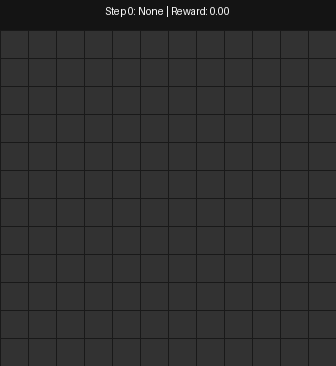

Ganó el demo: False


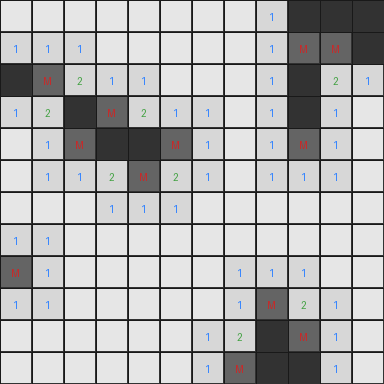

In [ ]:

N_EPISODES_BASELINE = 10000

random_policy = lambda env, obs, candidates, values, epsilon: (None, None, None)

baseline_stats = [
    run_episode_with_policy(
        policy_fn=random_policy,
        values={},
        epsilon=1.0,
        record_gif=False,
    )
    for _ in range(N_EPISODES_BASELINE)
]

baseline_wins = sum(s["won"] for s in baseline_stats)
baseline_rewards = [s["total_reward"] for s in baseline_stats]
baseline_steps = [s["steps"] for s in baseline_stats]

baseline_eval = {
    "win_rate": baseline_wins / N_EPISODES_BASELINE,
    "mean_reward": float(np.mean(baseline_rewards)),
    "mean_steps": float(np.mean(baseline_steps)),
}

print(f"Baseline aleatorio - Episodios: {N_EPISODES_BASELINE}")
print(f"Win-rate: {baseline_eval['win_rate']:.3f}")
print(f"Recompensa media (shaped): {baseline_eval['mean_reward']:.3f}")
print(f"Pasos medios: {baseline_eval['mean_steps']:.1f}")

# Demo de un episodio con GIF (tablero + ventanas elegidas)
demo = run_episode_with_policy(
    policy_fn=random_policy,
    values={},
    epsilon=1.0,
    record_gif=True,
    gif_name="episode_random.gif",
)
print("Ganó el demo:", demo["won"])
display(render_board_img(demo["env"], cell_px=32, show_mines=True))


## Celda 4 – Función de evaluación común para políticas basadas en ventanas

In [ ]:

def evaluate_window_values(values, episodes=200, epsilon_eval=0.0, verbose=True):
    """
    Evalúa una política greedy a partir de un diccionario state_key -> valor.
    Usa reward moldeado (shaped_reward) internamente.
    """
    wins = 0
    rewards = []
    steps = []

    def policy_eval(env, obs, candidates, values_dict, epsilon_not_used):
        return select_action_eps_greedy(candidates, values_dict, epsilon_eval)

    for _ in range(episodes):
        stats = run_episode_with_policy(
            policy_fn=policy_eval,
            values=values,
            epsilon=0.0,
            record_gif=False,
        )
        if stats["won"]:
            wins += 1
        rewards.append(stats["total_reward"])
        steps.append(stats["steps"])

    win_rate = wins / episodes
    mean_reward = float(np.mean(rewards))
    mean_steps = float(np.mean(steps))

    if verbose:
        print(f"Episodios de evaluación: {episodes}")
        print(f"Win-rate: {win_rate:.3f}")
        print(f"Recompensa media (shaped): {mean_reward:.3f}")
        print(f"Pasos medios: {mean_steps:.1f}")

    return {
        "win_rate": win_rate,
        "mean_reward": mean_reward,
        "mean_steps": mean_steps,
    }


## Celda 5 – Bandit contextual (ventana = brazo)

In [ ]:
def bandit_policy(env, obs, candidates, values, epsilon):
    """ε-greedy sobre Q(w), donde w es la ventana local."""
    return select_action_eps_greedy(candidates, values, epsilon)


def train_bandit(num_episodes=800, epsilon=0.1, alpha=0.1):
    """
    Entrenamiento tipo Bandit:
    Q(w) ≈ recompensa moldeada esperada al clickear una celda con ventana w.
    """
    values = defaultdict(float)
    history = {"episode_rewards": [], "episode_wins": []}

    for ep in range(num_episodes):
        env = make_env()
        obs, r0, done, info, start_cell = safe_reset_and_first_move(env)
        total_reward = r0
        episode_steps_data = [{"action": {"cell": start_cell, "type": "reveal", "local_window": env._get_window_observation(start_cell)},
                               "reward": r0, "info": info, "observation": obs}] # Guardar info del primer paso

        while not done:
            candidates = get_candidate_windows(env, obs)
            if not candidates:
                break

            state_key, cell, window = bandit_policy(env, obs, candidates, values, epsilon)
            if cell is None:
                break

            action = {"cell": cell, "type": "reveal", "local_window": window}
            obs_next, env_r, done, info = env.step(action)

            r = shaped_reward(env, window, env_r, info) # Calcular recompensa moldeada
            total_reward += r

            episode_steps_data.append({"action": action, "reward": r, "info": info, "observation": obs_next}) # Guardar info del paso

            # Actualización Bandit
            values[state_key] += alpha * (r - values[state_key])
            obs = obs_next # Actualizar observación para el siguiente paso

        history["episode_rewards"].append(total_reward)
        history["episode_wins"].append(1 if env.won else 0)

        if (ep + 1) % 200 == 0:
            mean_win = np.mean(history["episode_wins"][-200:])
            print(f"[Bandit] Episodio {ep+1}/{num_episodes} | win-rate últimos 200: {mean_win:.3f}")

    return dict(values), history


bandit_values, bandit_history = train_bandit(
    num_episodes=50000,
    epsilon=0.3,
    alpha=0.3,
)

print("\nWin-rate global (Bandit entrenamiento):", np.mean(bandit_history["episode_wins"]))
print("Evaluando Bandit (política greedy sobre ventanas):")
bandit_eval = evaluate_window_values(bandit_values, episodes=400, epsilon_eval=0.0)

[Bandit] Episodio 200/50000 | win-rate últimos 200: 0.000
[Bandit] Episodio 400/50000 | win-rate últimos 200: 0.000
[Bandit] Episodio 600/50000 | win-rate últimos 200: 0.000
[Bandit] Episodio 800/50000 | win-rate últimos 200: 0.000
[Bandit] Episodio 1000/50000 | win-rate últimos 200: 0.000
[Bandit] Episodio 1200/50000 | win-rate últimos 200: 0.000
[Bandit] Episodio 1400/50000 | win-rate últimos 200: 0.000
[Bandit] Episodio 1600/50000 | win-rate últimos 200: 0.000
[Bandit] Episodio 1800/50000 | win-rate últimos 200: 0.000
[Bandit] Episodio 2000/50000 | win-rate últimos 200: 0.005
[Bandit] Episodio 2200/50000 | win-rate últimos 200: 0.000
[Bandit] Episodio 2400/50000 | win-rate últimos 200: 0.000
[Bandit] Episodio 2600/50000 | win-rate últimos 200: 0.000
[Bandit] Episodio 2800/50000 | win-rate últimos 200: 0.005
[Bandit] Episodio 3000/50000 | win-rate últimos 200: 0.000
[Bandit] Episodio 3200/50000 | win-rate últimos 200: 0.000
[Bandit] Episodio 3400/50000 | win-rate últimos 200: 0.000
[

## Celda 6 – Control Monte Carlo (first-visit) sobre ventanas

In [ ]:

def mc_policy(env, obs, candidates, values, epsilon):
    """Política ε-greedy sobre V(w) usando Monte Carlo."""
    return select_action_eps_greedy(candidates, values, epsilon)


def train_monte_carlo(num_episodes=800, epsilon=0.1, gamma=0.99):
    """
    Monte Carlo first-visit:
    V(w) = valor esperado del retorno acumulado (recompensas moldeadas).
    """
    values = defaultdict(float)
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)

    history = {"episode_rewards": [], "episode_wins": []}

    for ep in range(num_episodes):
        env = make_env()
        obs, r0, done, info, start_cell = safe_reset_and_first_move(env)

        episode_states = []
        episode_rewards = [r0]  # incluye el primer movimiento
        total_reward = r0

        while not done:
            candidates = get_candidate_windows(env, obs)
            if not candidates:
                break

            state_key, cell, window = mc_policy(env, obs, candidates, values, epsilon)
            if cell is None:
                break

            action = {"cell": cell, "type": "reveal", "local_window": window}
            obs, env_r, done, info = env.step(action)

            r = shaped_reward(env, window, env_r, info)
            total_reward += r

            if env.history:
                env.history[-1]["action"]["local_window"] = window
                env.history[-1]["reward"] = r

            episode_states.append(state_key)
            episode_rewards.append(r)

        # Monte Carlo first-visit (sobre el episodio completo)
        G = 0.0
        visited = set()
        for t in reversed(range(len(episode_states))):
            s = episode_states[t]
            r_t = episode_rewards[t + 1]  # desplazado porque el primer reward fue r0
            G = gamma * G + r_t
            if s not in visited:
                visited.add(s)
                returns_sum[s] += G
                returns_count[s] += 1
                values[s] = returns_sum[s] / returns_count[s]

        history["episode_rewards"].append(total_reward)
        history["episode_wins"].append(1 if env.won else 0)

        if (ep + 1) % 200 == 0:
            mean_win = np.mean(history["episode_wins"][-200:])
            print(f"[MC] Episodio {ep+1}/{num_episodes} | win-rate últimos 200: {mean_win:.3f}")

    return dict(values), history


mc_values, mc_history = train_monte_carlo(
    num_episodes=50000,
    epsilon=0.3,
    gamma=0.99,
)

print("\nWin-rate global (MC entrenamiento):", np.mean(mc_history["episode_wins"]))
print("Evaluando MC (política greedy sobre ventanas):")
mc_eval = evaluate_window_values(mc_values, episodes=400, epsilon_eval=0.0)


[MC] Episodio 200/50000 | win-rate últimos 200: 0.000
[MC] Episodio 400/50000 | win-rate últimos 200: 0.000
[MC] Episodio 600/50000 | win-rate últimos 200: 0.000
[MC] Episodio 800/50000 | win-rate últimos 200: 0.000
[MC] Episodio 1000/50000 | win-rate últimos 200: 0.000
[MC] Episodio 1200/50000 | win-rate últimos 200: 0.000
[MC] Episodio 1400/50000 | win-rate últimos 200: 0.000
[MC] Episodio 1600/50000 | win-rate últimos 200: 0.000
[MC] Episodio 1800/50000 | win-rate últimos 200: 0.000
[MC] Episodio 2000/50000 | win-rate últimos 200: 0.000
[MC] Episodio 2200/50000 | win-rate últimos 200: 0.000
[MC] Episodio 2400/50000 | win-rate últimos 200: 0.000
[MC] Episodio 2600/50000 | win-rate últimos 200: 0.000
[MC] Episodio 2800/50000 | win-rate últimos 200: 0.000
[MC] Episodio 3000/50000 | win-rate últimos 200: 0.000
[MC] Episodio 3200/50000 | win-rate últimos 200: 0.000
[MC] Episodio 3400/50000 | win-rate últimos 200: 0.000
[MC] Episodio 3600/50000 | win-rate últimos 200: 0.000
[MC] Episodio 

## Celda 7 – Q-learning tabular sobre ventanas

In [ ]:

def q_policy(env, obs, candidates, Q, epsilon):
    """Política ε-greedy sobre Q(w)."""
    return select_action_eps_greedy(candidates, Q, epsilon)


def train_q_learning(num_episodes=800, epsilon=0.1, alpha=0.1, gamma=0.99):
    """
    Q-learning sobre ventanas:
    Q(w) ≈ retorno esperado (con recompensas moldeadas) al clickear una celda con ventana w.
    """
    Q = defaultdict(float)
    history = {"episode_rewards": [], "episode_wins": []}

    for ep in range(num_episodes):
        env = make_env()
        obs, r0, done, info, start_cell = safe_reset_and_first_move(env)
        total_reward = r0

        while not done:
            candidates = get_candidate_windows(env, obs)
            if not candidates:
                break

            state_key, cell, window = q_policy(env, obs, candidates, Q, epsilon)
            if cell is None:
                break

            action = {"cell": cell, "type": "reveal", "local_window": window}
            obs_next, env_r, done, info = env.step(action)

            r = shaped_reward(env, window, env_r, info)
            total_reward += r

            if env.history:
                env.history[-1]["action"]["local_window"] = window
                env.history[-1]["reward"] = r

            # Target TD
            if done:
                target = r
            else:
                candidates_next = get_candidate_windows(env, obs_next)
                if not candidates_next:
                    target = r
                else:
                    next_values = [Q.get(k, 0.0) for k in candidates_next.keys()]
                    best_next = max(next_values) if next_values else 0.0
                    target = r + gamma * best_next

            Q[state_key] += alpha * (target - Q[state_key])
            obs = obs_next

        history["episode_rewards"].append(total_reward)
        history["episode_wins"].append(1 if env.won else 0)

        if (ep + 1) % 200 == 0:
            mean_win = np.mean(history["episode_wins"][-200:])
            print(f"[Q] Episodio {ep+1}/{num_episodes} | win-rate últimos 200: {mean_win:.3f}")

    return dict(Q), history


q_values, q_history = train_q_learning(
    num_episodes=50000,
    epsilon=0.15,
    alpha=0.1,
    gamma=0.99,
)

print("\nWin-rate global (Q-learning entrenamiento):", np.mean(q_history["episode_wins"]))
print("Evaluando Q-learning (política greedy sobre ventanas):")
q_eval = evaluate_window_values(q_values, episodes=400, epsilon_eval=0.0)


[Q] Episodio 200/50000 | win-rate últimos 200: 0.000
[Q] Episodio 400/50000 | win-rate últimos 200: 0.000
[Q] Episodio 600/50000 | win-rate últimos 200: 0.000
[Q] Episodio 800/50000 | win-rate últimos 200: 0.000
[Q] Episodio 1000/50000 | win-rate últimos 200: 0.000
[Q] Episodio 1200/50000 | win-rate últimos 200: 0.000
[Q] Episodio 1400/50000 | win-rate últimos 200: 0.000
[Q] Episodio 1600/50000 | win-rate últimos 200: 0.010
[Q] Episodio 1800/50000 | win-rate últimos 200: 0.000
[Q] Episodio 2000/50000 | win-rate últimos 200: 0.000
[Q] Episodio 2200/50000 | win-rate últimos 200: 0.010
[Q] Episodio 2400/50000 | win-rate últimos 200: 0.010
[Q] Episodio 2600/50000 | win-rate últimos 200: 0.000
[Q] Episodio 2800/50000 | win-rate últimos 200: 0.005
[Q] Episodio 3000/50000 | win-rate últimos 200: 0.005
[Q] Episodio 3200/50000 | win-rate últimos 200: 0.000
[Q] Episodio 3400/50000 | win-rate últimos 200: 0.000
[Q] Episodio 3600/50000 | win-rate últimos 200: 0.000
[Q] Episodio 3800/50000 | win-ra

## Celda 9 – Política heurística local (reglas tipo humano)

In [ ]:
def heuristic_mine_probability(env, window: np.ndarray) -> float:
    """
    Estima P(mina en la celda central) usando solo la ventana local.

    Aproximación:
    - Por cada número revelado que vea a la celda central, calcula:
        minas_restantes / celdas_ocultas_vecinas
      y combina las probabilidades asumiendo independencia aproximada.
    """
    w = window
    ws = w.shape[0]
    center = ws // 2

    constraints = []

    for i in range(ws):
        for j in range(ws):
            val = int(w[i, j])
            if val < 0 or val == 9:
                continue  # oculto o bandera

            n = val
            flagged = 0
            hidden = 0
            candidate_is_neighbor = False

            for di in (-1, 0, 1):
                for dj in (-1, 0, 1):
                    if di == 0 and dj == 0:
                        continue
                    ni, nj = i + di, j + dj
                    if ni < 0 or nj < 0 or ni >= ws or nj >= ws:
                        continue

                    v2 = int(w[ni, nj])
                    if v2 == 9:
                        flagged += 1
                    elif v2 < 0:
                        hidden += 1

                    if ni == center and nj == center:
                        candidate_is_neighbor = True

            if not candidate_is_neighbor:
                continue

            remaining = n - flagged
            if remaining <= 0:
                constraints.append(0.0)
            elif hidden <= 0:
                constraints.append(1.0)
            else:
                p_j = remaining / hidden
                p_j = max(0.0, min(1.0, p_j))
                constraints.append(p_j)

    if constraints:
        p_not_mine = 1.0
        for p_j in constraints:
            p_not_mine *= (1.0 - p_j)
        p = 1.0 - p_not_mine
    else:
        # Sin info local, prior simple de densidad de minas
        p = env.num_mines / float(env.rows * env.cols)

    return max(0.0, min(1.0, p))


def heuristic_policy(env, obs, candidates, values_not_used, epsilon): # Aceptar epsilon
    """
    Escoge la celda con menor probabilidad estimada de ser mina, según la ventana.
    """
    best_p = float("inf")
    best_triplets = []

    for k, lst in candidates.items():
        for cell, w in lst:
            p = heuristic_mine_probability(env, w)
            if p < best_p - 1e-9:
                best_p = p
                best_triplets = [(k, cell, w)]
            elif abs(p - best_p) <= 1e-9:
                best_triplets.append((k, cell, w))

    if not best_triplets:
        return None, None, None

    return random.choice(best_triplets)


def evaluate_heuristic_policy(episodes: int = 400):
    """Evalúa la política heurística con reward moldeado."""
    wins = 0
    rewards = []
    steps = []

    for _ in range(episodes):
        stats = run_episode_with_policy(
            policy_fn=heuristic_policy,
            values={},
            epsilon=0.0,
            record_gif=False,
        )
        if stats["won"]:
            wins += 1
        rewards.append(stats["total_reward"])
        steps.append(stats["steps"])

    win_rate = wins / episodes
    mean_reward = float(np.mean(rewards))
    mean_steps = float(np.mean(steps))

    print(f"[Heurística] Evaluación en {episodes} episodios")
    print(f"Win-rate: {win_rate:.3f}")
    print(f"Recompensa media (shaped): {mean_reward:.3f}")
    print(f"Pasos medios: {mean_steps:.1f}")

    return {
        "win_rate": win_rate,
        "mean_reward": mean_reward,
        "mean_steps": mean_steps,
    }


heuristic_eval = evaluate_heuristic_policy(episodes=50000)

[Heurística] Evaluación en 50000 episodios
Win-rate: 0.018
Recompensa media (shaped): 23.269
Pasos medios: 8.0


## Celda 10 – Q-learning con red neuronal (MLP) sobre ventanas

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim


class WindowQNet(nn.Module):
    """MLP simple que estima Q(w) a partir de la ventana w."""
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)


def _window_to_tensor(window: np.ndarray) -> torch.Tensor:
    """Convierte una ventana a tensor 1D normalizado en [-1, 1] aprox."""
    arr = window.astype(np.float32)
    arr = arr / 8.0
    return torch.from_numpy(arr.flatten())


def train_nn_q_learning(
    num_episodes: int = 4000,
    gamma: float = 0.99,
    lr: float = 1e-3,
    epsilon_start: float = 0.3,
    epsilon_end: float = 0.01,
    epsilon_decay: float = 0.999,
):
    """
    Q-learning aproximado con red neuronal:
    Q_θ(w) ≈ retorno esperado (shaped) al clickear una celda con ventana w.
    """
    window_side = 2 * ENV_CONFIG["window_radius"] + 1
    input_dim = window_side * window_side

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    net = WindowQNet(input_dim).to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    history = {"episode_rewards": [], "episode_wins": []}
    state_examples = {}  # state_key -> última ventana vista con ese key

    def get_epsilon(ep_idx: int) -> float:
        return max(epsilon_end, epsilon_start * (epsilon_decay ** ep_idx))

    for ep in range(num_episodes):
        env = make_env()
        obs, r0, done, info, start_cell = safe_reset_and_first_move(env)
        total_reward = r0

        epsilon = get_epsilon(ep)

        while not done:
            candidates = get_candidate_windows(env, obs)
            if not candidates:
                break

            # Selección de acción ε-greedy usando la red
            if np.random.rand() < epsilon:
                state_key, cell, window = random_policy(env, obs, candidates, None, None)
            else:
                best_q = -np.inf
                best_triplets = []

                for k, lst in candidates.items():
                    for cell, w in lst:
                        x = _window_to_tensor(w).to(device).unsqueeze(0)
                        with torch.no_grad():
                            q_val = net(x).item()
                        if q_val > best_q:
                            best_q = q_val
                            best_triplets = [(k, cell, w)]
                        elif q_val == best_q:
                            best_triplets.append((k, cell, w))

                state_key, cell, window = random.choice(best_triplets)

            if cell is None:
                break

            state_examples[state_key] = window.copy()

            action = {"cell": cell, "type": "reveal", "local_window": window}
            obs_next, env_r, done, info = env.step(action)

            r = shaped_reward(env, window, env_r, info)
            total_reward += r

            if env.history:
                env.history[-1]["action"]["local_window"] = window
                env.history[-1]["reward"] = r

            # Actualización Q-learning con red
            x_s = _window_to_tensor(window).to(device).unsqueeze(0)
            q_pred = net(x_s)

            if done:
                target_val = r
            else:
                candidates_next = get_candidate_windows(env, obs_next)
                if not candidates_next:
                    target_val = r
                else:
                    best_next_q = -np.inf
                    for _, lst in candidates_next.items():
                        for _, w_next in lst:
                            x_next = _window_to_tensor(w_next).to(device).unsqueeze(0)
                            with torch.no_grad():
                                qn = net(x_next).item()
                            if qn > best_next_q:
                                best_next_q = qn
                    if best_next_q == -np.inf:
                        best_next_q = 0.0
                    target_val = r + gamma * best_next_q

            target = torch.tensor([target_val], dtype=torch.float32, device=device)
            loss = loss_fn(q_pred, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            obs = obs_next

        history["episode_rewards"].append(total_reward)
        history["episode_wins"].append(1 if env.won else 0)

        if (ep + 1) % 500 == 0:
            mean_win = np.mean(history["episode_wins"][-500:])
            print(f"[NN-Q] Episodio {ep+1}/{num_episodes} | win-rate últimos 500: {mean_win:.3f}")

    # Construir diccionario nn_q_values (para usar evaluate_window_values)
    nn_q_values = {}
    for state_key, w in state_examples.items():
        x = _window_to_tensor(w).to(device).unsqueeze(0)
        with torch.no_grad():
            q_val = net(x).item()
        nn_q_values[state_key] = q_val

    return net, nn_q_values, history


nn_q_net, nn_q_values, nn_q_history = train_nn_q_learning(
    num_episodes=50000,
    gamma=0.99,
    lr=1e-3,
    epsilon_start=0.3,
    epsilon_end=0.01,
    epsilon_decay=0.999,
)

print("\nWin-rate global (NN-Q entrenamiento):", np.mean(nn_q_history["episode_wins"]))
print("Evaluando NN-Q (política greedy sobre ventanas):")
nn_q_eval = evaluate_window_values(nn_q_values, episodes=400, epsilon_eval=0.0)


[NN-Q] Episodio 500/50000 | win-rate últimos 500: 0.000
[NN-Q] Episodio 1000/50000 | win-rate últimos 500: 0.002
[NN-Q] Episodio 1500/50000 | win-rate últimos 500: 0.006
[NN-Q] Episodio 2000/50000 | win-rate últimos 500: 0.002
[NN-Q] Episodio 2500/50000 | win-rate últimos 500: 0.006
[NN-Q] Episodio 3000/50000 | win-rate últimos 500: 0.004
[NN-Q] Episodio 3500/50000 | win-rate últimos 500: 0.008
[NN-Q] Episodio 4000/50000 | win-rate últimos 500: 0.010
[NN-Q] Episodio 4500/50000 | win-rate últimos 500: 0.004
[NN-Q] Episodio 5000/50000 | win-rate últimos 500: 0.006
[NN-Q] Episodio 5500/50000 | win-rate últimos 500: 0.000
[NN-Q] Episodio 6000/50000 | win-rate últimos 500: 0.008
[NN-Q] Episodio 6500/50000 | win-rate últimos 500: 0.006
[NN-Q] Episodio 7000/50000 | win-rate últimos 500: 0.000
[NN-Q] Episodio 7500/50000 | win-rate últimos 500: 0.008
[NN-Q] Episodio 8000/50000 | win-rate últimos 500: 0.006
[NN-Q] Episodio 8500/50000 | win-rate últimos 500: 0.006
[NN-Q] Episodio 9000/50000 | win

## Celda 11 – Comparación de métodos (win-rate y recompensa media)

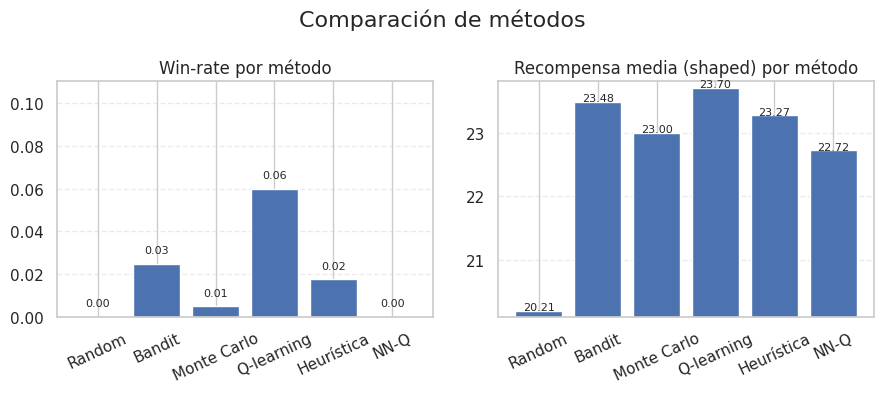

In [ ]:

import matplotlib.pyplot as plt

methods_eval = {
    "Random": baseline_eval,
    "Bandit": bandit_eval,
    "Monte Carlo": mc_eval,
    "Q-learning": q_eval,
    "Heurística": heuristic_eval,
    "NN-Q": nn_q_eval,
}

names = list(methods_eval.keys())
win_rates = [methods_eval[k]["win_rate"] for k in names]
mean_rewards = [methods_eval[k]["mean_reward"] for k in names]

plt.figure(figsize=(9, 4))
# Titulo global
plt.suptitle("Comparación de métodos", fontsize=16)
plt.subplot(1, 2, 1)
plt.bar(names, win_rates)
plt.title("Win-rate por método")
plt.xticks(rotation=25)
plt.ylim(0.0, max(win_rates) + 0.05)
for i, v in enumerate(win_rates):
    plt.text(i, v + 0.005, f"{v:.2f}", ha="center", fontsize=8)
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.subplot(1, 2, 2)
plt.bar(names, mean_rewards)
plt.title("Recompensa media (shaped) por método")
plt.xticks(rotation=25)
plt.ylim(min(mean_rewards) - 0.1, max(mean_rewards) + 0.1)
for i, v in enumerate(mean_rewards):
    plt.text(i, v + 0.01 * np.sign(v if v != 0 else 1), f"{v:.2f}", ha="center", fontsize=8)
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


Graficando historial de entrenamiento comparativo (figuras separadas, ventana 2000)...


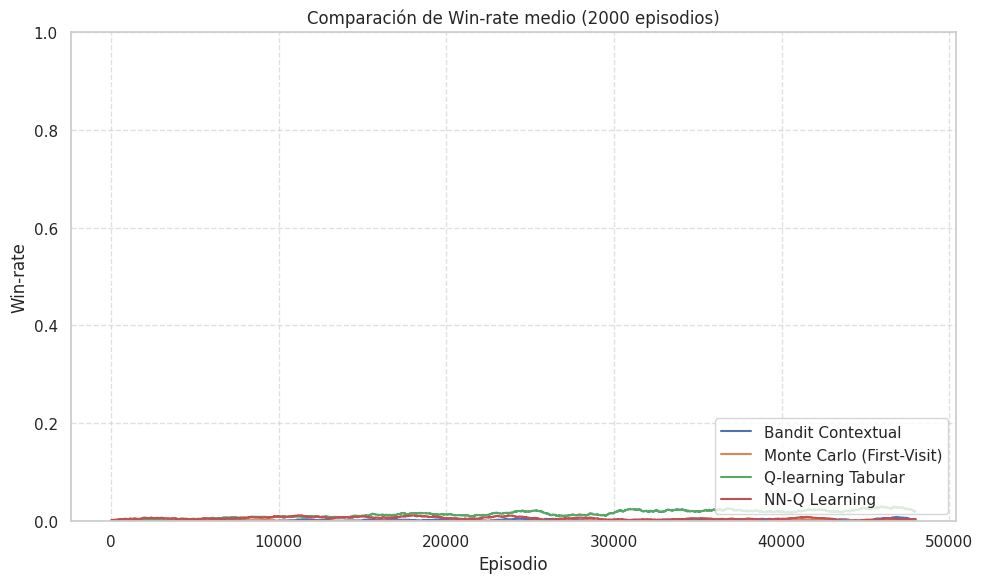

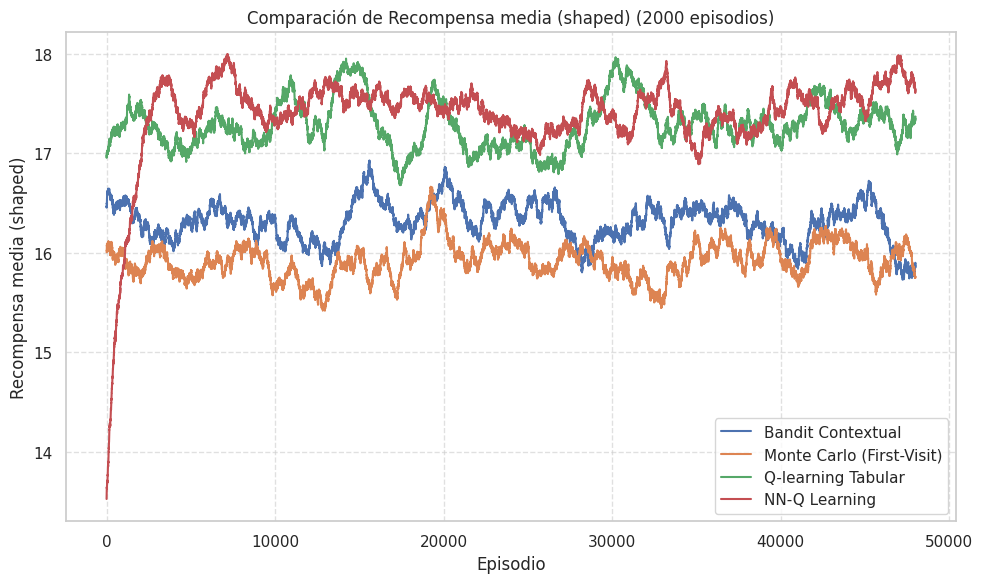

In [ ]:


sns.set_theme(style="whitegrid") # Usar un estilo de Seaborn

def plot_comparative_training_history_separated(histories, window_size=1000): # Cambiado a 2000
    """Grafica el historial de entrenamiento de varios métodos en figuras separadas con mejor estilo y ventana más grande."""

    # Figura para Win-rate
    plt.figure(figsize=(10, 6))
    for title, history in histories.items():
        if "episode_wins" in history and len(history["episode_wins"]) >= window_size:
            episode_wins_smoothed = np.convolve(history["episode_wins"], np.ones(window_size)/window_size, mode='valid')
            episodes = range(len(episode_wins_smoothed))
            plt.plot(episodes, episode_wins_smoothed, label=title)

    plt.title(f'Comparación de Win-rate medio ({window_size} episodios)')
    plt.xlabel("Episodio")
    plt.ylabel("Win-rate")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(loc='lower right') # Mover leyenda para no tapar curvas
    plt.ylim(0, 1.0) # Estandarizar eje Y para win-rate

    plt.tight_layout()
    plt.show()

    # Figura para Recompensa media
    plt.figure(figsize=(10, 6))
    for title, history in histories.items():
         if "episode_rewards" in history and len(history["episode_rewards"]) >= window_size:
            episode_rewards_smoothed = np.convolve(history["episode_rewards"], np.ones(window_size)/window_size, mode='valid')
            episodes = range(len(episode_rewards_smoothed))
            plt.plot(episodes, episode_rewards_smoothed, label=title)

    plt.title(f'Comparación de Recompensa media (shaped) ({window_size} episodios)')
    plt.xlabel("Episodio")
    plt.ylabel("Recompensa media (shaped)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(loc='lower right') # Mover leyenda
    # No estandarizamos el eje Y de recompensa porque los rangos pueden variar mucho

    plt.tight_layout()
    plt.show()




print("Graficando historial de entrenamiento comparativo (figuras separadas, ventana 2000)...")

# Diccionario con los historiales a comparar
all_histories = {
    "Bandit Contextual": bandit_history,
    "Monte Carlo (First-Visit)": mc_history,
    "Q-learning Tabular": q_history,
    "NN-Q Learning": nn_q_history,
}

plot_comparative_training_history_separated(all_histories, window_size=2000) # Usar la nueva ventana

## Celda 12 – GIFs de episodios con tablero + ventana por método


=== Buscando el mejor episodio para GIF con política Bandit ===
Encontrado el mejor episodio (Ganó: True, Recompensa: 27.20). Generando GIF...
GIF saved to episode_best_Bandit.gif



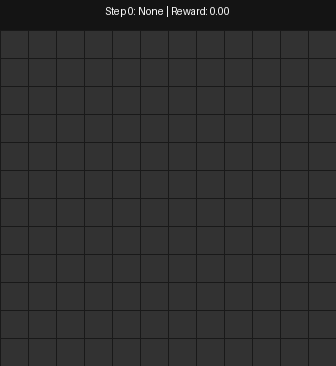

Ganó el episodio demo: True


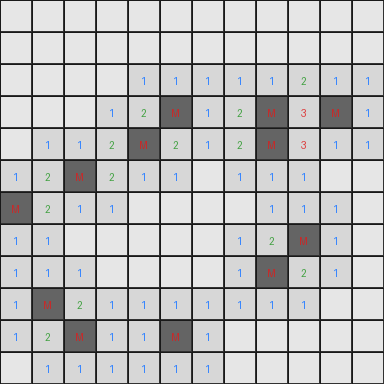


=== Buscando el mejor episodio para GIF con política MonteCarlo ===
Encontrado el mejor episodio (Ganó: True, Recompensa: 27.35). Generando GIF...
GIF saved to episode_best_MonteCarlo.gif



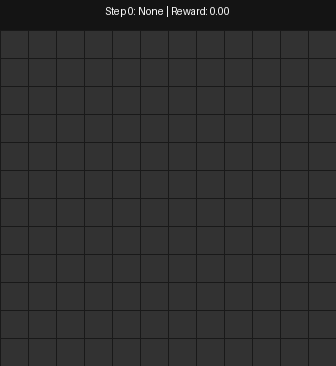

Ganó el episodio demo: True


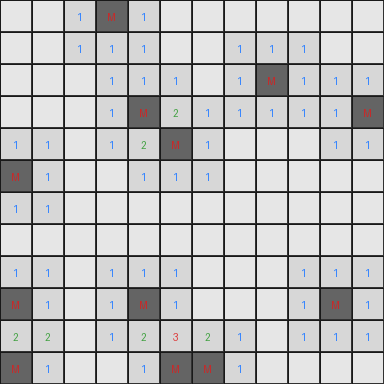


=== Buscando el mejor episodio para GIF con política Q-learning ===
Encontrado el mejor episodio (Ganó: True, Recompensa: 27.30). Generando GIF...
GIF saved to episode_best_Q-learning.gif



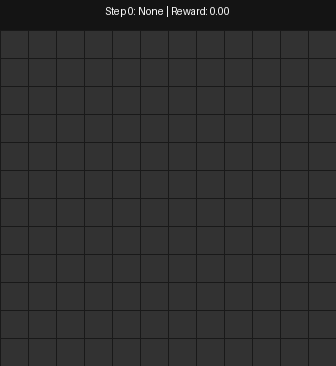

Ganó el episodio demo: True


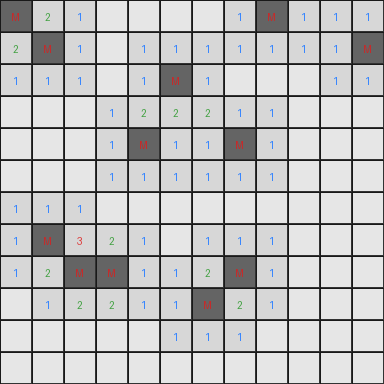


=== Buscando el mejor episodio para GIF con política Heurística ===
Encontrado el mejor episodio (Ganó: False, Recompensa: 25.10). Generando GIF...
GIF saved to episode_best_Heurística.gif



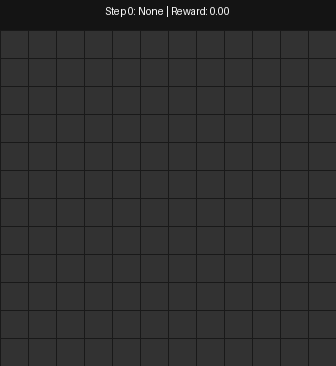

Ganó el episodio demo: False


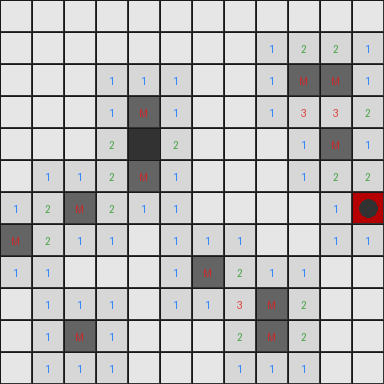


=== Buscando el mejor episodio para GIF con política NN-Q ===
Encontrado el mejor episodio (Ganó: False, Recompensa: 24.59). Generando GIF...
GIF saved to episode_best_NN-Q.gif



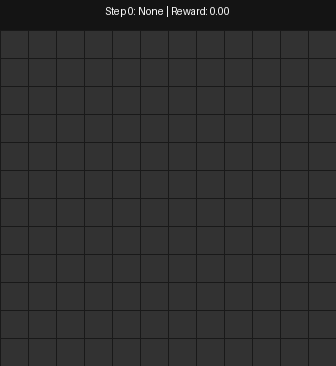

Ganó el episodio demo: False


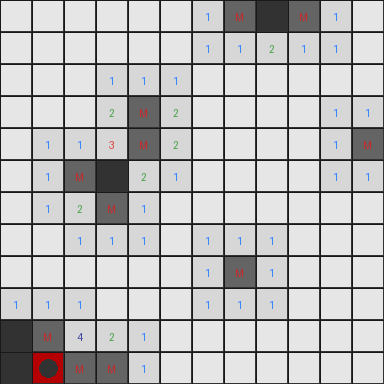

In [ ]:
def greedy_from_values(values_dict):
    """Devuelve una política greedy pura a partir de un dict de valores."""
    # Corregir la firma para aceptar 'epsilon' (aunque lo ignoremos)
    def _policy(env, obs, candidates, values, epsilon): # Cambiado a 'epsilon'
        return select_action_eps_greedy(candidates, values_dict, epsilon=0.0) # Siempre greedy
    return _policy


# Para NN usamos el dict nn_q_values; si quieres, puedes cambiar a una versión
# que consulte directamente la red, pero así se mantiene homogéneo.
method_policies = {
    "Bandit": (bandit_values, greedy_from_values(bandit_values)),
    "MonteCarlo": (mc_values, greedy_from_values(mc_values)),
    "Q-learning": (q_values, greedy_from_values(q_values)),
    "Heurística": ({}, heuristic_policy),
    "NN-Q": (nn_q_values, greedy_from_values(nn_q_values)),
}

N_DEMO_EPISODES = 50 # Número de episodios para encontrar el mejor para el GIF

for name, (vals, pol) in method_policies.items():
    print(f"\n=== Buscando el mejor episodio para GIF con política {name} ===")
    best_stats = None

    for _ in range(N_DEMO_EPISODES):
        # run_episode_with_policy ahora guarda el historial completo
        stats = run_episode_with_policy(
            policy_fn=pol,
            values=vals,
            epsilon=0.0, # Política greedy para la demo
            record_gif=False, # No grabar GIF aún
        )

        # Criterio de "mejor": priorizar ganar, luego recompensa
        if best_stats is None or \
           stats["won"] > best_stats["won"] or \
           (stats["won"] == best_stats["won"] and stats["total_reward"] > best_stats["total_reward"]):
            best_stats = stats


    # Generar GIF solo para el mejor episodio encontrado
    if best_stats and best_stats.get("env") and best_stats["env"].history:
        print(f"Encontrado el mejor episodio (Ganó: {best_stats['won']}, Recompensa: {best_stats['total_reward']:.2f}). Generando GIF...")

        gif_path = create_episode_gif(
            best_stats["env"], # Usar el entorno del mejor episodio que ya tiene el historial completo
            output_path=f"episode_best_{name}.gif",
            cell_px=28,
            duration=0.5,
            show_windows=True,
        )
        display_gif_inline(gif_path)
        print("Ganó el episodio demo:", best_stats["won"]) # Mostrar el resultado de la partida real
        display(render_board_img(best_stats["env"], cell_px=32, show_mines=True)) # Mostrar el tablero final del mejor episodio

    else:
        print(f"No se encontraron episodios válidos para {name} después de {N_DEMO_EPISODES} intentos.")

# Evaluación con tablero pequeño 5x5

In [ ]:


# Tablero "amigable" para que los agentes sí puedan aprender algo
ENV_CONFIG["rows"] = 5
ENV_CONFIG["cols"] = 5
ENV_CONFIG["num_mines"] = 5
bandit_values, bandit_history = train_bandit(
    num_episodes=50000,
    epsilon=0.3,
    alpha=0.3,
)

print("\nWin-rate global (Bandit entrenamiento):", np.mean(bandit_history["episode_wins"]))
print("Evaluando Bandit (política greedy sobre ventanas):")
bandit_eval = evaluate_window_values(bandit_values, episodes=400, epsilon_eval=0.0)
mc_values, mc_history = train_monte_carlo(
    num_episodes=50000,
    epsilon=0.3,
    gamma=0.99,
)

print("\nWin-rate global (MC entrenamiento):", np.mean(mc_history["episode_wins"]))
print("Evaluando MC (política greedy sobre ventanas):")
mc_eval = evaluate_window_values(mc_values, episodes=400, epsilon_eval=0.0)
q_values, q_history = train_q_learning(
    num_episodes=50000,
    epsilon=0.15,
    alpha=0.1,
    gamma=0.99,
)

print("\nWin-rate global (Q-learning entrenamiento):", np.mean(q_history["episode_wins"]))
print("Evaluando Q-learning (política greedy sobre ventanas):")
q_eval = evaluate_window_values(q_values, episodes=400, epsilon_eval=0.0)
heuristic_eval = evaluate_heuristic_policy(episodes=10000)
nn_q_net, nn_q_values, nn_q_history = train_nn_q_learning(
    num_episodes=50000,
    gamma=0.99,
    lr=1e-3,
    epsilon_start=0.3,
    epsilon_end=0.01,
    epsilon_decay=0.999,
)

print("\nWin-rate global (NN-Q entrenamiento):", np.mean(nn_q_history["episode_wins"]))
print("Evaluando NN-Q (política greedy sobre ventanas):")
nn_q_eval = evaluate_window_values(nn_q_values, episodes=400, epsilon_eval=0.0)


[Bandit] Episodio 200/50000 | win-rate últimos 200: 0.040
[Bandit] Episodio 400/50000 | win-rate últimos 200: 0.010
[Bandit] Episodio 600/50000 | win-rate últimos 200: 0.025
[Bandit] Episodio 800/50000 | win-rate últimos 200: 0.045
[Bandit] Episodio 1000/50000 | win-rate últimos 200: 0.060
[Bandit] Episodio 1200/50000 | win-rate últimos 200: 0.060
[Bandit] Episodio 1400/50000 | win-rate últimos 200: 0.025
[Bandit] Episodio 1600/50000 | win-rate últimos 200: 0.035
[Bandit] Episodio 1800/50000 | win-rate últimos 200: 0.035
[Bandit] Episodio 2000/50000 | win-rate últimos 200: 0.045
[Bandit] Episodio 2200/50000 | win-rate últimos 200: 0.045
[Bandit] Episodio 2400/50000 | win-rate últimos 200: 0.075
[Bandit] Episodio 2600/50000 | win-rate últimos 200: 0.050
[Bandit] Episodio 2800/50000 | win-rate últimos 200: 0.030
[Bandit] Episodio 3000/50000 | win-rate últimos 200: 0.050
[Bandit] Episodio 3200/50000 | win-rate últimos 200: 0.065
[Bandit] Episodio 3400/50000 | win-rate últimos 200: 0.070
[

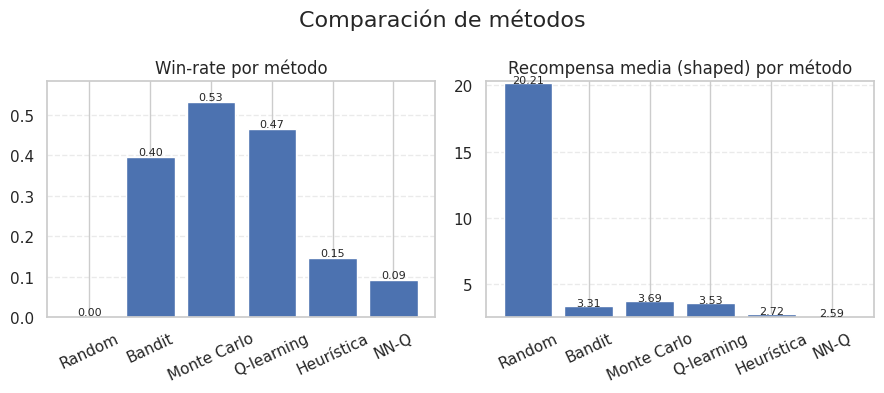

In [ ]:

import matplotlib.pyplot as plt

methods_eval = {
    "Random": baseline_eval,
    "Bandit": bandit_eval,
    "Monte Carlo": mc_eval,
    "Q-learning": q_eval,
    "Heurística": heuristic_eval,
    "NN-Q": nn_q_eval,
}

names = list(methods_eval.keys())
win_rates = [methods_eval[k]["win_rate"] for k in names]
mean_rewards = [methods_eval[k]["mean_reward"] for k in names]

plt.figure(figsize=(9, 4))
# Titulo global
plt.suptitle("Comparación de métodos", fontsize=16)

plt.subplot(1, 2, 1)
plt.bar(names, win_rates)
plt.title("Win-rate por método")
plt.xticks(rotation=25)
plt.ylim(0.0, max(win_rates) + 0.05)
for i, v in enumerate(win_rates):
    plt.text(i, v + 0.005, f"{v:.2f}", ha="center", fontsize=8)
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.subplot(1, 2, 2)
plt.bar(names, mean_rewards)
plt.title("Recompensa media (shaped) por método")
plt.xticks(rotation=25)
plt.ylim(min(mean_rewards) - 0.1, max(mean_rewards) + 0.1)
for i, v in enumerate(mean_rewards):
    plt.text(i, v + 0.01 * np.sign(v if v != 0 else 1), f"{v:.2f}", ha="center", fontsize=8)
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


# Serie de tiempo del entrenamiento.

Graficando historial de entrenamiento comparativo (figuras separadas, ventana 2000)...


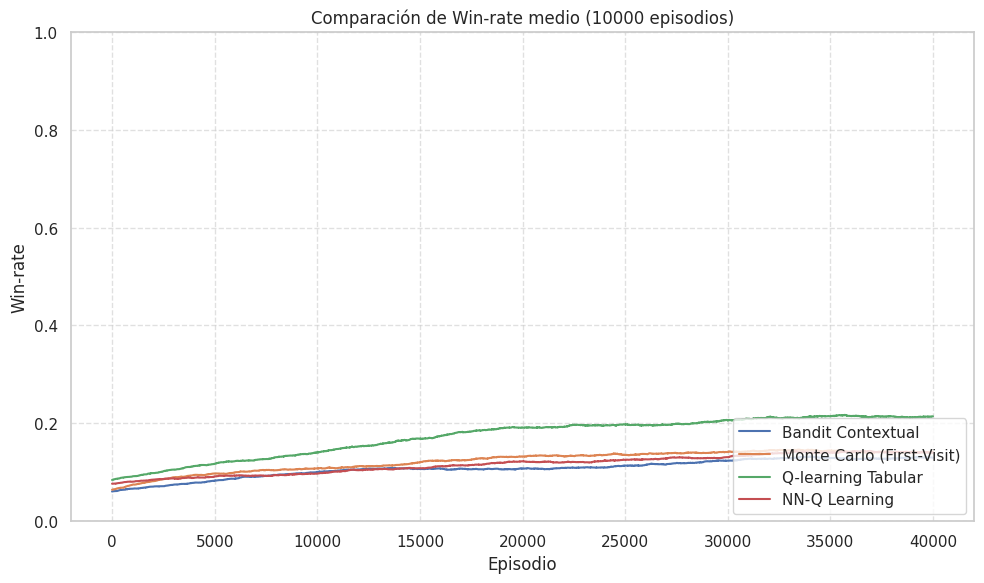

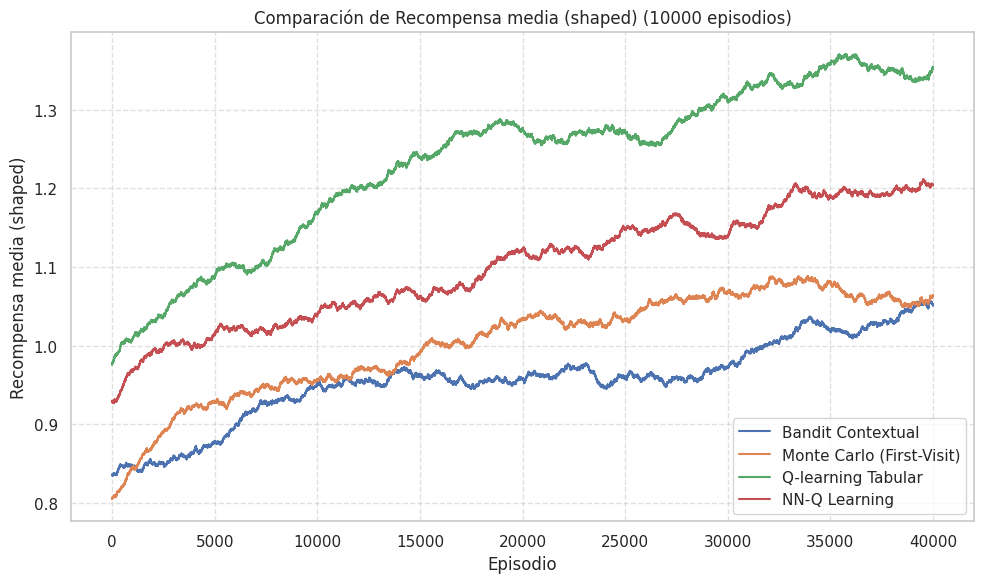

In [100]:



print("Graficando historial de entrenamiento comparativo (figuras separadas, ventana 2000)...")

# Diccionario con los historiales a comparar
all_histories = {
    "Bandit Contextual": bandit_history,
    "Monte Carlo (First-Visit)": mc_history,
    "Q-learning Tabular": q_history,
    "NN-Q Learning": nn_q_history,
}

plot_comparative_training_history_separated(all_histories, window_size=10000) # Usar la nueva ventana


=== Buscando el mejor episodio para GIF con política Bandit ===
Encontrado el mejor episodio (Ganó: True, Recompensa: 4.98). Generando GIF...
GIF saved to episode_best_Bandit.gif



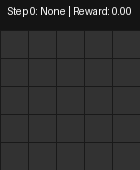

Ganó el episodio demo: True


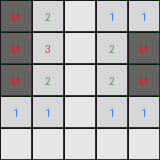


=== Buscando el mejor episodio para GIF con política MonteCarlo ===
Encontrado el mejor episodio (Ganó: True, Recompensa: 4.97). Generando GIF...
GIF saved to episode_best_MonteCarlo.gif



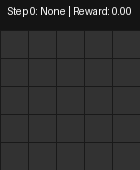

Ganó el episodio demo: True


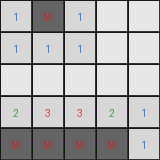


=== Buscando el mejor episodio para GIF con política Q-learning ===
Encontrado el mejor episodio (Ganó: True, Recompensa: 4.98). Generando GIF...
GIF saved to episode_best_Q-learning.gif



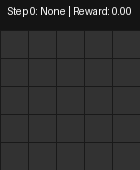

Ganó el episodio demo: True


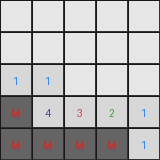


=== Buscando el mejor episodio para GIF con política Heurística ===
Encontrado el mejor episodio (Ganó: True, Recompensa: 4.99). Generando GIF...
GIF saved to episode_best_Heurística.gif



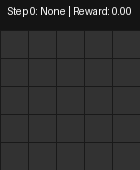

Ganó el episodio demo: True


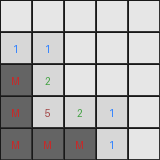


=== Buscando el mejor episodio para GIF con política NN-Q ===
Encontrado el mejor episodio (Ganó: True, Recompensa: 4.98). Generando GIF...
GIF saved to episode_best_NN-Q.gif



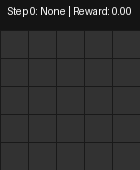

Ganó el episodio demo: True


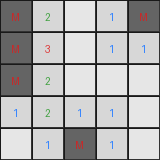

In [ ]:
def greedy_from_values(values_dict):
    """Devuelve una política greedy pura a partir de un dict de valores."""
    # Corregir la firma para aceptar 'epsilon' (aunque lo ignoremos)
    def _policy(env, obs, candidates, values, epsilon): # Cambiado a 'epsilon'
        return select_action_eps_greedy(candidates, values_dict, epsilon=0.0) # Siempre greedy
    return _policy


# Para NN usamos el dict nn_q_values; si quieres, puedes cambiar a una versión
# que consulte directamente la red, pero así se mantiene homogéneo.
method_policies = {
    "Bandit": (bandit_values, greedy_from_values(bandit_values)),
    "MonteCarlo": (mc_values, greedy_from_values(mc_values)),
    "Q-learning": (q_values, greedy_from_values(q_values)),
    "Heurística": ({}, heuristic_policy),
    "NN-Q": (nn_q_values, greedy_from_values(nn_q_values)),
}

N_DEMO_EPISODES = 50 # Número de episodios para encontrar el mejor para el GIF

for name, (vals, pol) in method_policies.items():
    print(f"\n=== Buscando el mejor episodio para GIF con política {name} ===")
    best_stats = None

    for _ in range(N_DEMO_EPISODES):
        # run_episode_with_policy ahora guarda el historial completo
        stats = run_episode_with_policy(
            policy_fn=pol,
            values=vals,
            epsilon=0.0, # Política greedy para la demo
            record_gif=False, # No grabar GIF aún
        )

        # Criterio de "mejor": priorizar ganar, luego recompensa
        if best_stats is None or \
           stats["won"] > best_stats["won"] or \
           (stats["won"] == best_stats["won"] and stats["total_reward"] > best_stats["total_reward"]):
            best_stats = stats


    # Generar GIF solo para el mejor episodio encontrado
    if best_stats and best_stats.get("env") and best_stats["env"].history:
        print(f"Encontrado el mejor episodio (Ganó: {best_stats['won']}, Recompensa: {best_stats['total_reward']:.2f}). Generando GIF...")

        gif_path = create_episode_gif(
            best_stats["env"], # Usar el entorno del mejor episodio que ya tiene el historial completo
            output_path=f"episode_best_{name}.gif",
            cell_px=28,
            duration=0.5,
            show_windows=True,
        )
        display_gif_inline(gif_path)
        print("Ganó el episodio demo:", best_stats["won"]) # Mostrar el resultado de la partida real
        display(render_board_img(best_stats["env"], cell_px=32, show_mines=True)) # Mostrar el tablero final del mejor episodio

    else:
        print(f"No se encontraron episodios válidos para {name} después de {N_DEMO_EPISODES} intentos.")